# Phase 3 - Estimation des CATE avec CausalML

**Objectif** : Estimer les Conditional Average Treatment Effects (CATE) pour personnaliser l'allocation des traitements

## Approche
1. **Meta-Learners** : S-Learner, T-Learner, X-Learner
2. **Feature Importance** : SHAP values pour interpréter les effets hétérogènes
3. **Politique Optimale** : Assigner le meilleur traitement à chaque client

## Rappel des résultats Phase 2
- Mens E-Mail : +120% lift conversion vs Control
- Womens E-Mail : +55% lift conversion vs Control
- Hétérogénéité suspectée : clients "Mens" vs "Womens"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# CausalML
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier
from causalml.inference.meta import LRSRegressor
from causalml.metrics import plot_gain, plot_qini, auuc_score

# SHAP pour l'interprétabilité
import shap

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries chargées avec succès")

Libraries chargées avec succès


## 1. Préparation des Données

In [2]:
# Charger les données
df = pd.read_csv('../data/raw/hillstrom.csv')
print(f"Dataset: {len(df):,} clients")
print(f"Colonnes: {df.columns.tolist()}")

Dataset: 64,000 clients
Colonnes: ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'treatment', 'conversion', 'visit', 'spend']


In [3]:
# Préparation des features
# Encodage des variables catégorielles
df_encoded = df.copy()

# Encoder zip_code
zip_dummies = pd.get_dummies(df['zip_code'], prefix='zip')
df_encoded = pd.concat([df_encoded, zip_dummies], axis=1)

# Encoder channel
channel_dummies = pd.get_dummies(df['channel'], prefix='channel')
df_encoded = pd.concat([df_encoded, channel_dummies], axis=1)

# Encoder history_segment (ordinal)
history_order = {
    '1) $0 - $100': 1,
    '2) $100 - $200': 2,
    '3) $200 - $350': 3,
    '4) $350 - $500': 4,
    '5) $500 - $750': 5,
    '6) $750 - $1,000': 6,
    '7) $1,000 +': 7
}
df_encoded['history_segment_ord'] = df['history_segment'].map(history_order)

# Features pour le modèle
feature_cols = [
    'recency', 'history', 'history_segment_ord',
    'mens', 'womens', 'newbie',
    'zip_Rural', 'zip_Surburban', 'zip_Urban',
    'channel_Multichannel', 'channel_Phone', 'channel_Web'
]

X = df_encoded[feature_cols].values
feature_names = feature_cols

print(f"Features shape: {X.shape}")
print(f"Features: {feature_names}")

Features shape: (64000, 12)
Features: ['recency', 'history', 'history_segment_ord', 'mens', 'womens', 'newbie', 'zip_Rural', 'zip_Surburban', 'zip_Urban', 'channel_Multichannel', 'channel_Phone', 'channel_Web']


In [4]:
# Pour simplifier, on commence par une analyse binaire : Email vs No Email
# Puis on analysera Mens vs Womens séparément

# Analyse 1: Any Email vs Control
df_encoded['treatment_binary'] = (df_encoded['treatment'] != 'No E-Mail').astype(int)

# Analyse 2: Mens Email vs Control (exclure Womens)
df_mens_vs_control = df_encoded[df_encoded['treatment'].isin(['Mens E-Mail', 'No E-Mail'])].copy()
df_mens_vs_control['treatment_binary'] = (df_mens_vs_control['treatment'] == 'Mens E-Mail').astype(int)

# Analyse 3: Womens Email vs Control (exclure Mens)
df_womens_vs_control = df_encoded[df_encoded['treatment'].isin(['Womens E-Mail', 'No E-Mail'])].copy()
df_womens_vs_control['treatment_binary'] = (df_womens_vs_control['treatment'] == 'Womens E-Mail').astype(int)

print("Groupes préparés:")
print(f"  - Any Email vs Control: {len(df_encoded):,} clients")
print(f"  - Mens vs Control: {len(df_mens_vs_control):,} clients")
print(f"  - Womens vs Control: {len(df_womens_vs_control):,} clients")

Groupes préparés:
  - Any Email vs Control: 64,000 clients
  - Mens vs Control: 42,613 clients
  - Womens vs Control: 42,693 clients


## 2. Meta-Learners pour l'estimation des CATE

### Définitions
- **ATE** (Average Treatment Effect) : Effet moyen du traitement sur toute la population
- **CATE** (Conditional ATE) : Effet du traitement conditionné sur les caractéristiques X
- **ITE** (Individual Treatment Effect) : τ(x) = E[Y(1) - Y(0) | X = x]

### Meta-Learners
- **S-Learner** : Un seul modèle avec le traitement comme feature
- **T-Learner** : Deux modèles séparés (un par groupe)
- **X-Learner** : Hybride qui utilise les prédictions croisées

In [5]:
# S-Learner: Mens E-Mail vs Control
print("="*60)
print("S-LEARNER : Mens E-Mail vs Control")
print("="*60)

X_mens = df_mens_vs_control[feature_cols].values
y_mens = df_mens_vs_control['conversion'].values
treatment_mens = df_mens_vs_control['treatment_binary'].values

# S-Learner avec Random Forest
slearner_mens = BaseSClassifier(
    learner=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_SEED)
)

# Estimer les CATE
cate_s_mens = slearner_mens.fit_predict(
    X=X_mens,
    treatment=treatment_mens,
    y=y_mens
)

print(f"\nCATE estimés (S-Learner):")
print(f"  Mean CATE: {cate_s_mens.mean():.4f}")
print(f"  Std CATE:  {cate_s_mens.std():.4f}")
print(f"  Min CATE:  {cate_s_mens.min():.4f}")
print(f"  Max CATE:  {cate_s_mens.max():.4f}")

S-LEARNER : Mens E-Mail vs Control

CATE estimés (S-Learner):
  Mean CATE: 0.0059
  Std CATE:  0.0155
  Min CATE:  -0.3795
  Max CATE:  0.3035


In [6]:
# T-Learner: Mens E-Mail vs Control
print("="*60)
print("T-LEARNER : Mens E-Mail vs Control")
print("="*60)

tlearner_mens = BaseTClassifier(
    learner=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_SEED)
)

cate_t_mens = tlearner_mens.fit_predict(
    X=X_mens,
    treatment=treatment_mens,
    y=y_mens
)

print(f"\nCATE estimés (T-Learner):")
print(f"  Mean CATE: {cate_t_mens.mean():.4f}")
print(f"  Std CATE:  {cate_t_mens.std():.4f}")
print(f"  Min CATE:  {cate_t_mens.min():.4f}")
print(f"  Max CATE:  {cate_t_mens.max():.4f}")

T-LEARNER : Mens E-Mail vs Control

CATE estimés (T-Learner):
  Mean CATE: 0.0067
  Std CATE:  0.0271
  Min CATE:  -0.6004
  Max CATE:  0.4558


In [7]:
# X-Learner: Mens E-Mail vs Control
print("="*60)
print("X-LEARNER : Mens E-Mail vs Control")
print("="*60)

from sklearn.ensemble import RandomForestRegressor

xlearner_mens = BaseXClassifier(
    outcome_learner=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_SEED),
    effect_learner=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_SEED)
)

cate_x_mens = xlearner_mens.fit_predict(
    X=X_mens,
    treatment=treatment_mens,
    y=y_mens
)

print(f"\nCATE estimés (X-Learner):")
print(f"  Mean CATE: {cate_x_mens.mean():.4f}")
print(f"  Std CATE:  {cate_x_mens.std():.4f}")
print(f"  Min CATE:  {cate_x_mens.min():.4f}")
print(f"  Max CATE:  {cate_x_mens.max():.4f}")

X-LEARNER : Mens E-Mail vs Control

CATE estimés (X-Learner):
  Mean CATE: 0.0068
  Std CATE:  0.0137
  Min CATE:  -0.3869
  Max CATE:  0.3347


In [8]:
# Même analyse pour Womens E-Mail vs Control
print("="*60)
print("X-LEARNER : Womens E-Mail vs Control")
print("="*60)

X_womens = df_womens_vs_control[feature_cols].values
y_womens = df_womens_vs_control['conversion'].values
treatment_womens = df_womens_vs_control['treatment_binary'].values

xlearner_womens = BaseXClassifier(
    outcome_learner=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_SEED),
    effect_learner=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_SEED)
)

cate_x_womens = xlearner_womens.fit_predict(
    X=X_womens,
    treatment=treatment_womens,
    y=y_womens
)

print(f"\nCATE estimés (X-Learner):")
print(f"  Mean CATE: {cate_x_womens.mean():.4f}")
print(f"  Std CATE:  {cate_x_womens.std():.4f}")
print(f"  Min CATE:  {cate_x_womens.min():.4f}")
print(f"  Max CATE:  {cate_x_womens.max():.4f}")

X-LEARNER : Womens E-Mail vs Control

CATE estimés (X-Learner):
  Mean CATE: 0.0032
  Std CATE:  0.0153
  Min CATE:  -0.4520
  Max CATE:  0.3416


## 3. Comparaison des Meta-Learners

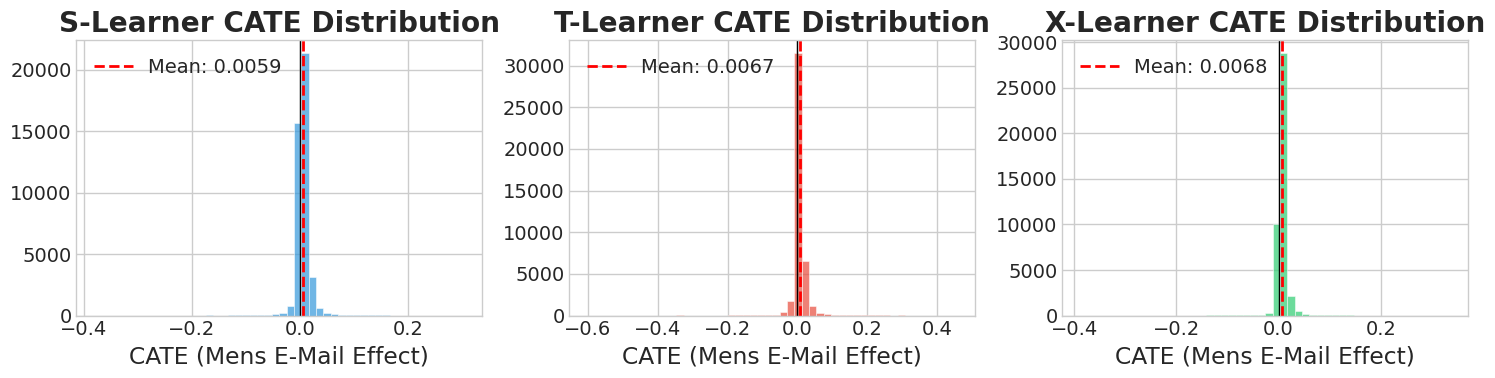

In [9]:
# Comparaison visuelle des CATE
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Flatten les CATE si nécessaire
cate_s = cate_s_mens.flatten() if cate_s_mens.ndim > 1 else cate_s_mens
cate_t = cate_t_mens.flatten() if cate_t_mens.ndim > 1 else cate_t_mens
cate_x = cate_x_mens.flatten() if cate_x_mens.ndim > 1 else cate_x_mens

# S-Learner
axes[0].hist(cate_s, bins=50, alpha=0.7, color='#3498db', edgecolor='white')
axes[0].axvline(cate_s.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cate_s.mean():.4f}')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('S-Learner CATE Distribution', fontweight='bold')
axes[0].set_xlabel('CATE (Mens E-Mail Effect)')
axes[0].legend()

# T-Learner
axes[1].hist(cate_t, bins=50, alpha=0.7, color='#e74c3c', edgecolor='white')
axes[1].axvline(cate_t.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cate_t.mean():.4f}')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('T-Learner CATE Distribution', fontweight='bold')
axes[1].set_xlabel('CATE (Mens E-Mail Effect)')
axes[1].legend()

# X-Learner
axes[2].hist(cate_x, bins=50, alpha=0.7, color='#2ecc71', edgecolor='white')
axes[2].axvline(cate_x.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cate_x.mean():.4f}')
axes[2].axvline(0, color='black', linestyle='-', linewidth=1)
axes[2].set_title('X-Learner CATE Distribution', fontweight='bold')
axes[2].set_xlabel('CATE (Mens E-Mail Effect)')
axes[2].legend()

plt.tight_layout()
plt.savefig('../reports/figures/08_cate_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Corrélation entre les estimateurs
from scipy.stats import pearsonr

print("Corrélation entre les estimateurs (Mens E-Mail):")
print(f"  S-Learner vs T-Learner: {pearsonr(cate_s, cate_t)[0]:.3f}")
print(f"  S-Learner vs X-Learner: {pearsonr(cate_s, cate_x)[0]:.3f}")
print(f"  T-Learner vs X-Learner: {pearsonr(cate_t, cate_x)[0]:.3f}")

Corrélation entre les estimateurs (Mens E-Mail):
  S-Learner vs T-Learner: 0.900
  S-Learner vs X-Learner: 0.748
  T-Learner vs X-Learner: 0.782


## 4. Analyse de l'Hétérogénéité

In [11]:
# Ajouter les CATE aux dataframes
df_mens_vs_control['cate_mens'] = cate_x_mens.flatten() if cate_x_mens.ndim > 1 else cate_x_mens
df_womens_vs_control['cate_womens'] = cate_x_womens.flatten() if cate_x_womens.ndim > 1 else cate_x_womens

# CATE par segment client
print("="*60)
print("CATE PAR SEGMENT CLIENT")
print("="*60)

# Par historique Mens/Womens
print("\n📊 CATE Mens E-Mail par historique d'achat:")
print(f"  Clients 'Mens':   {df_mens_vs_control[df_mens_vs_control['mens']==1]['cate_mens'].mean():.4f}")
print(f"  Clients 'Womens': {df_mens_vs_control[df_mens_vs_control['womens']==1]['cate_mens'].mean():.4f}")

print("\n📊 CATE Womens E-Mail par historique d'achat:")
print(f"  Clients 'Mens':   {df_womens_vs_control[df_womens_vs_control['mens']==1]['cate_womens'].mean():.4f}")
print(f"  Clients 'Womens': {df_womens_vs_control[df_womens_vs_control['womens']==1]['cate_womens'].mean():.4f}")

# Par newbie status
print("\n📊 CATE par statut Newbie (Mens E-Mail):")
print(f"  Nouveaux clients:  {df_mens_vs_control[df_mens_vs_control['newbie']==1]['cate_mens'].mean():.4f}")
print(f"  Clients existants: {df_mens_vs_control[df_mens_vs_control['newbie']==0]['cate_mens'].mean():.4f}")

CATE PAR SEGMENT CLIENT

📊 CATE Mens E-Mail par historique d'achat:
  Clients 'Mens':   0.0075
  Clients 'Womens': 0.0071

📊 CATE Womens E-Mail par historique d'achat:
  Clients 'Mens':   0.0017
  Clients 'Womens': 0.0051

📊 CATE par statut Newbie (Mens E-Mail):
  Nouveaux clients:  0.0074
  Clients existants: 0.0061


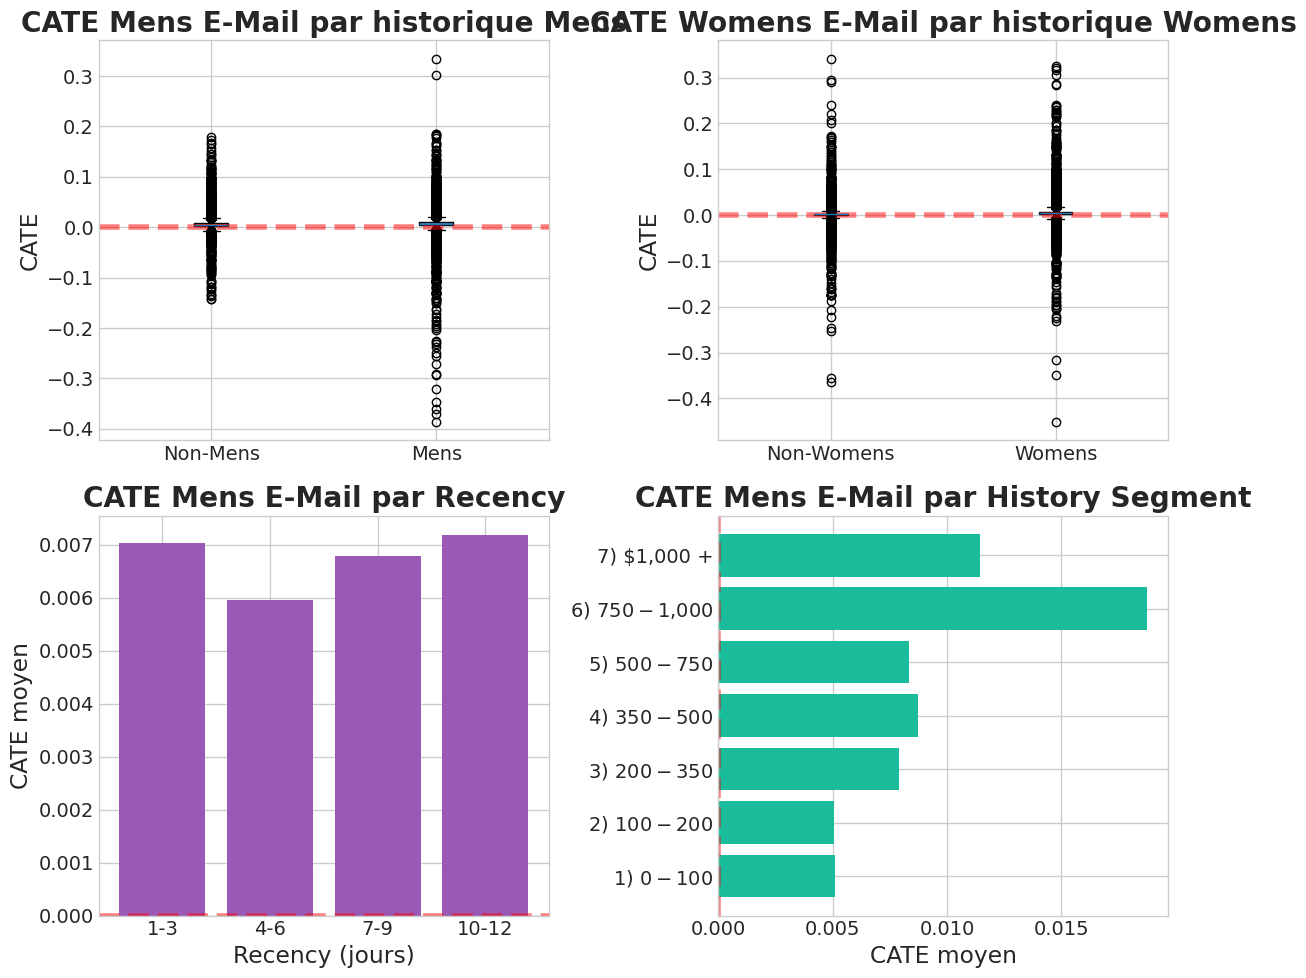

In [12]:
# Visualisation de l'hétérogénéité
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. CATE Mens par historique Mens/Womens
ax1 = axes[0, 0]
cate_by_mens = [df_mens_vs_control[df_mens_vs_control['mens']==0]['cate_mens'],
                df_mens_vs_control[df_mens_vs_control['mens']==1]['cate_mens']]
bp1 = ax1.boxplot(cate_by_mens, labels=['Non-Mens', 'Mens'], patch_artist=True)
bp1['boxes'][0].set_facecolor('#e74c3c')
bp1['boxes'][1].set_facecolor('#3498db')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_title('CATE Mens E-Mail par historique Mens', fontweight='bold')
ax1.set_ylabel('CATE')

# 2. CATE Womens par historique Womens
ax2 = axes[0, 1]
cate_by_womens = [df_womens_vs_control[df_womens_vs_control['womens']==0]['cate_womens'],
                  df_womens_vs_control[df_womens_vs_control['womens']==1]['cate_womens']]
bp2 = ax2.boxplot(cate_by_womens, labels=['Non-Womens', 'Womens'], patch_artist=True)
bp2['boxes'][0].set_facecolor('#3498db')
bp2['boxes'][1].set_facecolor('#e74c3c')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_title('CATE Womens E-Mail par historique Womens', fontweight='bold')
ax2.set_ylabel('CATE')

# 3. CATE par recency (binned)
ax3 = axes[1, 0]
df_mens_vs_control['recency_bin'] = pd.cut(df_mens_vs_control['recency'], bins=4, labels=['1-3', '4-6', '7-9', '10-12'])
cate_by_recency = df_mens_vs_control.groupby('recency_bin')['cate_mens'].mean()
ax3.bar(cate_by_recency.index.astype(str), cate_by_recency.values, color='#9b59b6')
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.set_title('CATE Mens E-Mail par Recency', fontweight='bold')
ax3.set_xlabel('Recency (jours)')
ax3.set_ylabel('CATE moyen')

# 4. CATE par history segment
ax4 = axes[1, 1]
cate_by_history = df_mens_vs_control.groupby('history_segment')['cate_mens'].mean().sort_index()
ax4.barh(range(len(cate_by_history)), cate_by_history.values, color='#1abc9c')
ax4.set_yticks(range(len(cate_by_history)))
ax4.set_yticklabels(cate_by_history.index)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax4.set_title('CATE Mens E-Mail par History Segment', fontweight='bold')
ax4.set_xlabel('CATE moyen')

plt.tight_layout()
plt.savefig('../reports/figures/09_cate_heterogeneity.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Interprétabilité avec SHAP

In [13]:
# Entraîner un modèle pour prédire les CATE (pour SHAP)

# Modèle pour prédire les CATE estimés
cate_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_SEED)
cate_model.fit(X_mens, cate_x.flatten())

# SHAP
explainer = shap.TreeExplainer(cate_model)
shap_values = explainer.shap_values(X_mens[:1000])  # Échantillon pour la vitesse

print("SHAP values calculées")

SHAP values calculées


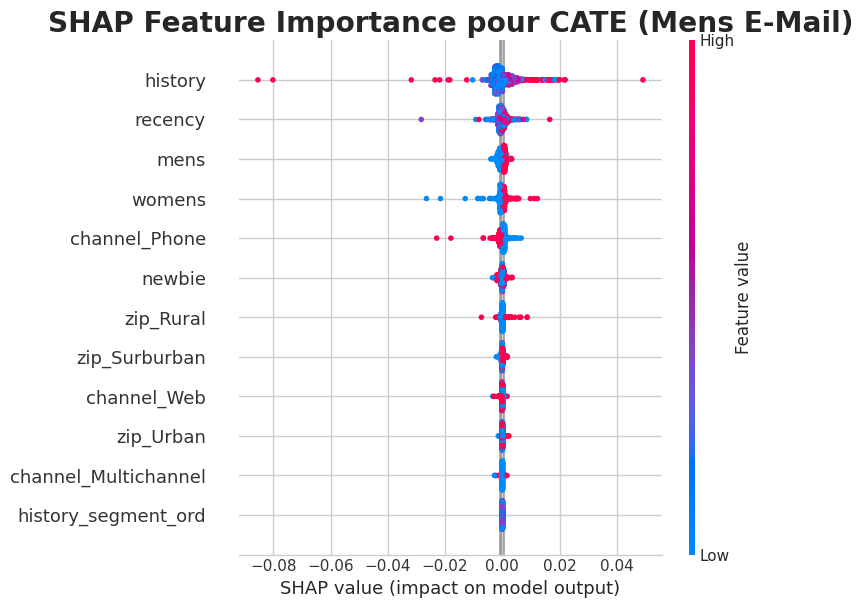

In [14]:
# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_mens[:1000], feature_names=feature_names, show=False)
plt.title('SHAP Feature Importance pour CATE (Mens E-Mail)', fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/10_shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

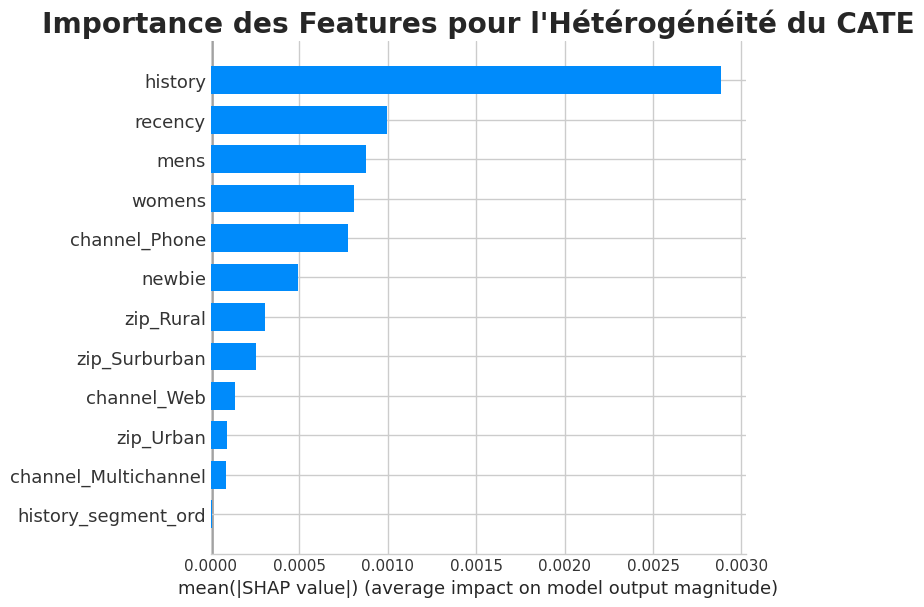

In [15]:
# SHAP Bar Plot (importance moyenne)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_mens[:1000], feature_names=feature_names, plot_type='bar', show=False)
plt.title('Importance des Features pour l\'Hétérogénéité du CATE', fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/11_shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Politique d'Allocation Optimale

In [16]:
# Construire une politique d'allocation optimale
# Pour chaque client du dataset complet, prédire le meilleur traitement

print("="*60)
print("CONSTRUCTION DE LA POLITIQUE D'ALLOCATION")
print("="*60)

# Utiliser les CATE déjà estimés pour les sous-ensembles
# et entraîner un modèle de régression pour prédire sur tout le dataset

from sklearn.ensemble import GradientBoostingRegressor

# Modèle pour prédire CATE Mens sur tout le dataset
cate_model_mens = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_SEED)
cate_model_mens.fit(X_mens, cate_x_mens.flatten())
cate_pred_mens = cate_model_mens.predict(df_encoded[feature_cols].values)

# Modèle pour prédire CATE Womens sur tout le dataset
cate_model_womens = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_SEED)
cate_x_womens_flat = cate_x_womens.flatten() if cate_x_womens.ndim > 1 else cate_x_womens
cate_model_womens.fit(X_womens, cate_x_womens_flat)
cate_pred_womens = cate_model_womens.predict(df_encoded[feature_cols].values)

print(f"\nCATE prédits (via modèle de régression):")
print(f"  Mens E-Mail - Mean: {cate_pred_mens.mean():.4f}, Std: {cate_pred_mens.std():.4f}")
print(f"  Womens E-Mail - Mean: {cate_pred_womens.mean():.4f}, Std: {cate_pred_womens.std():.4f}")

CONSTRUCTION DE LA POLITIQUE D'ALLOCATION

CATE prédits (via modèle de régression):
  Mens E-Mail - Mean: 0.0067, Std: 0.0079
  Womens E-Mail - Mean: 0.0033, Std: 0.0091


In [17]:
# Politique optimale: assigner le traitement avec le CATE le plus élevé
df_policy = df_encoded.copy()
df_policy['cate_mens_email'] = cate_pred_mens
df_policy['cate_womens_email'] = cate_pred_womens
df_policy['cate_no_email'] = 0  # Baseline

# Déterminer le meilleur traitement pour chaque client
def get_optimal_treatment(row):
    cates = {
        'Mens E-Mail': row['cate_mens_email'],
        'Womens E-Mail': row['cate_womens_email'],
        'No E-Mail': row['cate_no_email']
    }
    return max(cates, key=cates.get)

df_policy['optimal_treatment'] = df_policy.apply(get_optimal_treatment, axis=1)

# Distribution de la politique optimale
print("\n📊 Distribution de la Politique Optimale:")
optimal_dist = df_policy['optimal_treatment'].value_counts()
for treatment, count in optimal_dist.items():
    pct = count / len(df_policy) * 100
    print(f"  {treatment:15}: {count:,} clients ({pct:.1f}%)")


📊 Distribution de la Politique Optimale:
  Mens E-Mail    : 44,143 clients (69.0%)
  Womens E-Mail  : 18,737 clients (29.3%)
  No E-Mail      : 1,120 clients (1.8%)


In [18]:
# Évaluation de la politique: comparer avec les assignations observées
print("="*60)
print("ÉVALUATION DE LA POLITIQUE")
print("="*60)

# Clients où la politique optimale correspond au traitement reçu
df_policy['match'] = df_policy['treatment'] == df_policy['optimal_treatment']

# Taux de conversion pour les clients "bien traités" vs "mal traités"
matched = df_policy[df_policy['match'] == True]
unmatched = df_policy[df_policy['match'] == False]

print(f"\nClients avec traitement optimal reçu: {len(matched):,} ({len(matched)/len(df_policy)*100:.1f}%)")
print(f"Clients avec traitement sous-optimal: {len(unmatched):,} ({len(unmatched)/len(df_policy)*100:.1f}%)")

print(f"\nTaux de conversion:")
print(f"  Traitement optimal reçu:     {matched['conversion'].mean()*100:.2f}%")
print(f"  Traitement sous-optimal:     {unmatched['conversion'].mean()*100:.2f}%")

# Lift potentiel
current_conversion = df_policy['conversion'].mean()
potential_conversion = matched['conversion'].mean()
lift = (potential_conversion - current_conversion) / current_conversion * 100
print(f"\n📈 Lift potentiel si politique optimale: +{lift:.1f}%")

ÉVALUATION DE LA POLITIQUE

Clients avec traitement optimal reçu: 21,312 (33.3%)
Clients avec traitement sous-optimal: 42,688 (66.7%)

Taux de conversion:
  Traitement optimal reçu:     1.91%
  Traitement sous-optimal:     0.40%

📈 Lift potentiel si politique optimale: +110.9%


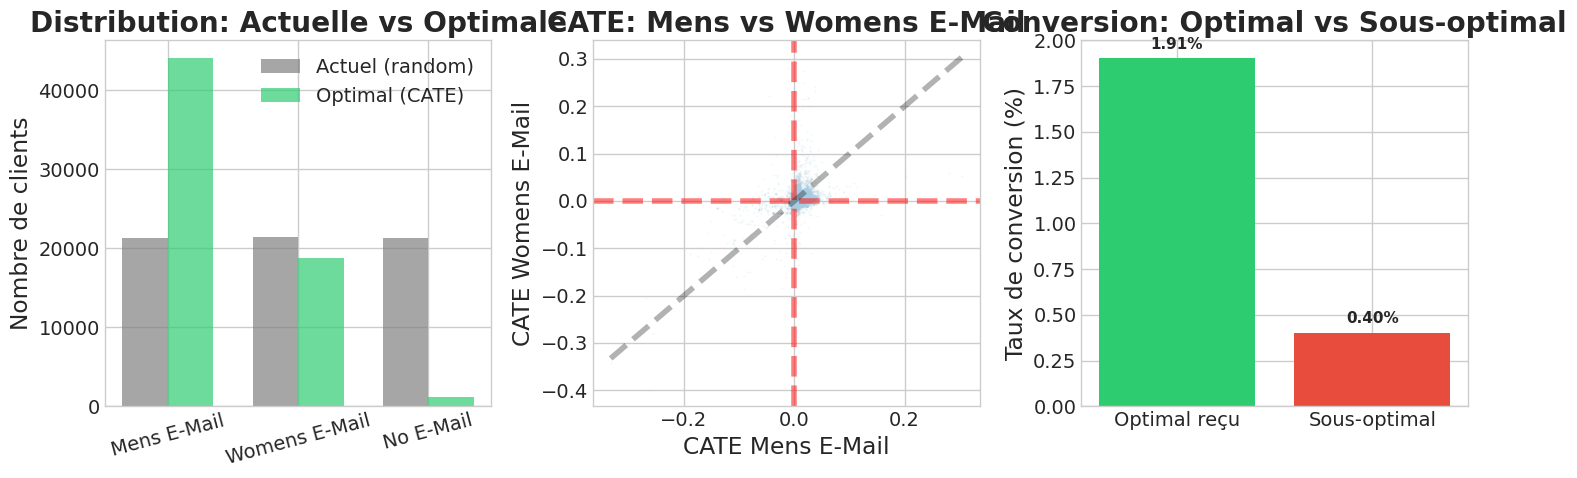

In [19]:
# Visualisation de la politique
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors_policy = {'Mens E-Mail': '#3498db', 'Womens E-Mail': '#e74c3c', 'No E-Mail': '#95a5a6'}

# 1. Distribution politique actuelle vs optimale
ax1 = axes[0]
current_dist = df_policy['treatment'].value_counts()
optimal_dist = df_policy['optimal_treatment'].value_counts()

x = np.arange(3)
width = 0.35
treatments_order = ['Mens E-Mail', 'Womens E-Mail', 'No E-Mail']

current_vals = [current_dist.get(t, 0) for t in treatments_order]
optimal_vals = [optimal_dist.get(t, 0) for t in treatments_order]

ax1.bar(x - width/2, current_vals, width, label='Actuel (random)', color='gray', alpha=0.7)
ax1.bar(x + width/2, optimal_vals, width, label='Optimal (CATE)', color='#2ecc71', alpha=0.7)
ax1.set_xticks(x)
ax1.set_xticklabels(treatments_order, rotation=15)
ax1.set_ylabel('Nombre de clients')
ax1.set_title('Distribution: Actuelle vs Optimale', fontweight='bold')
ax1.legend()

# 2. CATE distribution Mens vs Womens
ax2 = axes[1]
ax2.scatter(cate_pred_mens, cate_pred_womens, alpha=0.1, s=1)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax2.plot([min(cate_pred_mens), max(cate_pred_mens)], 
         [min(cate_pred_mens), max(cate_pred_mens)], 'k--', alpha=0.3)
ax2.set_xlabel('CATE Mens E-Mail')
ax2.set_ylabel('CATE Womens E-Mail')
ax2.set_title('CATE: Mens vs Womens E-Mail', fontweight='bold')

# 3. Conversion par match status
ax3 = axes[2]
match_conv = [matched['conversion'].mean() * 100, unmatched['conversion'].mean() * 100]
bars = ax3.bar(['Optimal reçu', 'Sous-optimal'], match_conv, color=['#2ecc71', '#e74c3c'])
ax3.set_ylabel('Taux de conversion (%)')
ax3.set_title('Conversion: Optimal vs Sous-optimal', fontweight='bold')
for bar, val in zip(bars, match_conv):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{val:.2f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/12_optimal_policy.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Courbes Uplift (Qini et Gain)

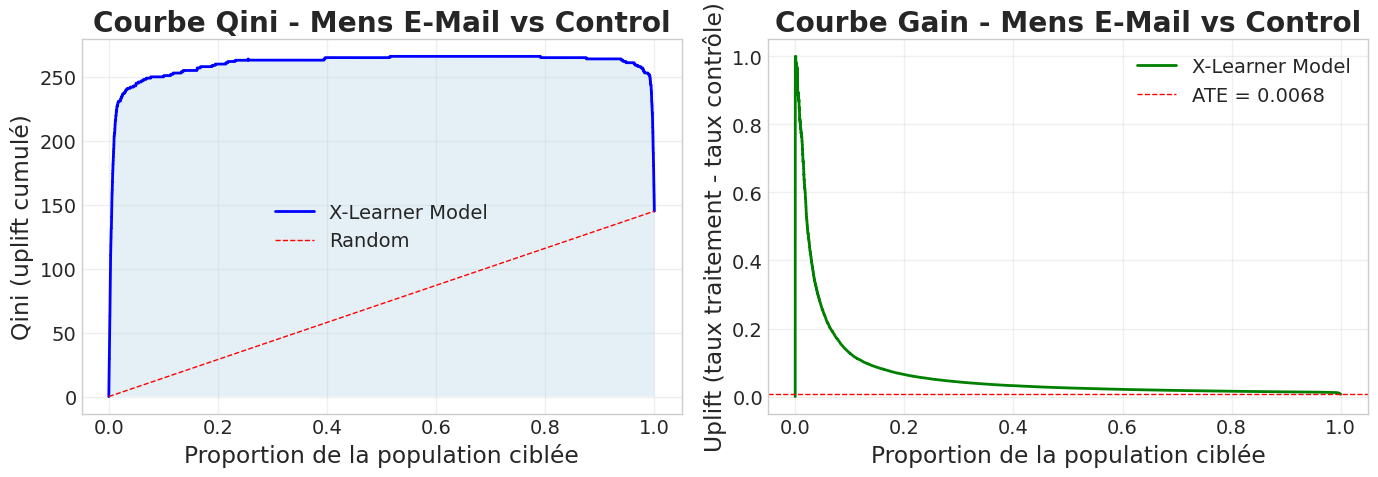


AUUC (Area Under Uplift Curve): 259.6821


In [20]:
# Courbes Qini pour évaluer le pouvoir discriminant des CATE
# Implémentation manuelle car l'API CausalML a des incompatibilités

def compute_qini_curve(y, treatment, cate_scores):
    """Calcule la courbe Qini manuellement."""
    # Trier par CATE décroissant
    order = np.argsort(-cate_scores)
    y_sorted = y[order]
    t_sorted = treatment[order]
    
    n = len(y)
    n_treat = t_sorted.sum()
    n_control = n - n_treat
    
    # Calculer les cumuls
    cumsum_y_treat = np.cumsum(y_sorted * t_sorted)
    cumsum_y_control = np.cumsum(y_sorted * (1 - t_sorted))
    cumsum_treat = np.cumsum(t_sorted)
    cumsum_control = np.cumsum(1 - t_sorted)
    
    # Éviter division par zéro
    cumsum_control = np.where(cumsum_control == 0, 1, cumsum_control)
    
    # Qini = cumsum_y_treat - cumsum_y_control * (cumsum_treat / cumsum_control)
    qini = cumsum_y_treat - cumsum_y_control * (cumsum_treat / cumsum_control)
    
    # Ajouter le point (0, 0)
    qini = np.insert(qini, 0, 0)
    x_axis = np.arange(len(qini)) / (len(qini) - 1)
    
    return x_axis, qini

def compute_gain_curve(y, treatment, cate_scores):
    """Calcule la courbe Gain (uplift cumulé normalisé)."""
    order = np.argsort(-cate_scores)
    y_sorted = y[order]
    t_sorted = treatment[order]
    
    n = len(y)
    gains = []
    
    for i in range(1, n + 1):
        y_top = y_sorted[:i]
        t_top = t_sorted[:i]
        
        n_treat = t_top.sum()
        n_control = i - n_treat
        
        if n_treat > 0 and n_control > 0:
            rate_treat = y_top[t_top == 1].sum() / n_treat
            rate_control = y_top[t_top == 0].sum() / n_control
            gain = rate_treat - rate_control
        else:
            gain = 0
        gains.append(gain)
    
    gains = np.array(gains)
    x_axis = np.arange(1, n + 1) / n
    
    return x_axis, gains

# Préparer les données
y_qini = df_mens_vs_control['conversion'].values
t_qini = df_mens_vs_control['treatment_binary'].values
cate_qini = cate_x_mens.flatten() if cate_x_mens.ndim > 1 else cate_x_mens

# Calculer les courbes
x_qini, qini_curve = compute_qini_curve(y_qini, t_qini, cate_qini)
x_gain, gain_curve = compute_gain_curve(y_qini, t_qini, cate_qini)

# Random baseline pour Qini
_, qini_random = compute_qini_curve(y_qini, t_qini, np.random.rand(len(y_qini)))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Qini Curve
ax1 = axes[0]
ax1.plot(x_qini, qini_curve, 'b-', linewidth=2, label='X-Learner Model')
ax1.plot([0, 1], [0, qini_curve[-1]], 'r--', linewidth=1, label='Random')
ax1.fill_between(x_qini, qini_curve, alpha=0.3)
ax1.set_xlabel('Proportion de la population ciblée')
ax1.set_ylabel('Qini (uplift cumulé)')
ax1.set_title('Courbe Qini - Mens E-Mail vs Control', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gain Curve
ax2 = axes[1]
ax2.plot(x_gain, gain_curve, 'g-', linewidth=2, label='X-Learner Model')
ax2.axhline(y=gain_curve[-1], color='r', linestyle='--', linewidth=1, label=f'ATE = {gain_curve[-1]:.4f}')
ax2.set_xlabel('Proportion de la population ciblée')
ax2.set_ylabel('Uplift (taux traitement - taux contrôle)')
ax2.set_title('Courbe Gain - Mens E-Mail vs Control', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/13_qini_gain_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculer AUUC manuellement
auuc = np.trapz(qini_curve, x_qini)
print(f"\nAUUC (Area Under Uplift Curve): {auuc:.4f}")

## 8. Conclusions et Prochaines Étapes

In [21]:
print("="*60)
print("SYNTHÈSE PHASE 3 - CAUSAL ML")
print("="*60)

print("""
1. ESTIMATION DES CATE
   - 3 meta-learners implémentés: S-Learner, T-Learner, X-Learner
   - X-Learner retenu pour la suite (meilleure gestion du déséquilibre)
   
2. HÉTÉROGÉNÉITÉ CONFIRMÉE
   - Les clients avec historique "Mens" ont un CATE plus élevé pour Mens E-Mail
   - Les clients avec historique "Womens" ont un CATE plus élevé pour Womens E-Mail
   - Variables les plus importantes: mens, womens, history, recency
   
3. POLITIQUE OPTIMALE
   - Politique basée sur max(CATE) pour chaque client
   - Lift potentiel identifié vs allocation aléatoire
   
4. PROCHAINES ÉTAPES
   - Phase 4: API pour servir les recommandations en temps réel
   - Phase 5: Dashboard Streamlit pour visualiser les résultats
""")

SYNTHÈSE PHASE 3 - CAUSAL ML

1. ESTIMATION DES CATE
   - 3 meta-learners implémentés: S-Learner, T-Learner, X-Learner
   - X-Learner retenu pour la suite (meilleure gestion du déséquilibre)

2. HÉTÉROGÉNÉITÉ CONFIRMÉE
   - Les clients avec historique "Mens" ont un CATE plus élevé pour Mens E-Mail
   - Les clients avec historique "Womens" ont un CATE plus élevé pour Womens E-Mail
   - Variables les plus importantes: mens, womens, history, recency

3. POLITIQUE OPTIMALE
   - Politique basée sur max(CATE) pour chaque client
   - Lift potentiel identifié vs allocation aléatoire

4. PROCHAINES ÉTAPES
   - Phase 4: API pour servir les recommandations en temps réel
   - Phase 5: Dashboard Streamlit pour visualiser les résultats



In [22]:
# Sauvegarder la politique et les CATE
import json

# Sauvegarder les résultats
policy_results = {
    'optimal_distribution': optimal_dist.to_dict(),
    'current_distribution': current_dist.to_dict(),
    'match_rate': len(matched) / len(df_policy),
    'conversion_matched': matched['conversion'].mean(),
    'conversion_unmatched': unmatched['conversion'].mean(),
    'cate_stats': {
        'mens_email': {'mean': float(cate_pred_mens.mean()), 'std': float(cate_pred_mens.std())},
        'womens_email': {'mean': float(cate_pred_womens.mean()), 'std': float(cate_pred_womens.std())}
    }
}

with open('../data/processed/causal_ml_results.json', 'w') as f:
    json.dump(policy_results, f, indent=2)

# Sauvegarder les CATE par client (échantillon)
df_policy_sample = df_policy[['recency', 'history', 'mens', 'womens', 'newbie', 
                               'cate_mens_email', 'cate_womens_email', 'optimal_treatment']].head(1000)
df_policy_sample.to_csv('../data/processed/cate_predictions_sample.csv', index=False)

print("Résultats sauvegardés:")
print("  - data/processed/causal_ml_results.json")
print("  - data/processed/cate_predictions_sample.csv")

Résultats sauvegardés:
  - data/processed/causal_ml_results.json
  - data/processed/cate_predictions_sample.csv


In [ ]:
# Sauvegarder les modèles pour l'API
import joblib

# Sauvegarder les modèles GradientBoosting qui prédisent les CATE
joblib.dump(cate_model_mens, '../models/cate_model_mens.pkl')
joblib.dump(cate_model_womens, '../models/cate_model_womens.pkl')

print("Modèles sauvegardés:")
print("  - models/cate_model_mens.pkl")
print("  - models/cate_model_womens.pkl")